In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure plotting
plt.style.use('default')
sns.set_theme(style="whitegrid")

In [2]:
# Load data
data_dir = Path('../data/raw')
train_features = pd.read_csv(data_dir / 'train_features.csv')
test_features = pd.read_csv(data_dir / 'test_features.csv')
train_labels = pd.read_csv(data_dir / 'train_labels.csv')

In [3]:
# Basic information about datasets
print("Train features shape:", train_features.shape)
print("Test features shape:", test_features.shape)
print("Train labels shape:", train_labels.shape)

Train features shape: (3276, 184)
Test features shape: (819, 184)
Train labels shape: (4343, 3)


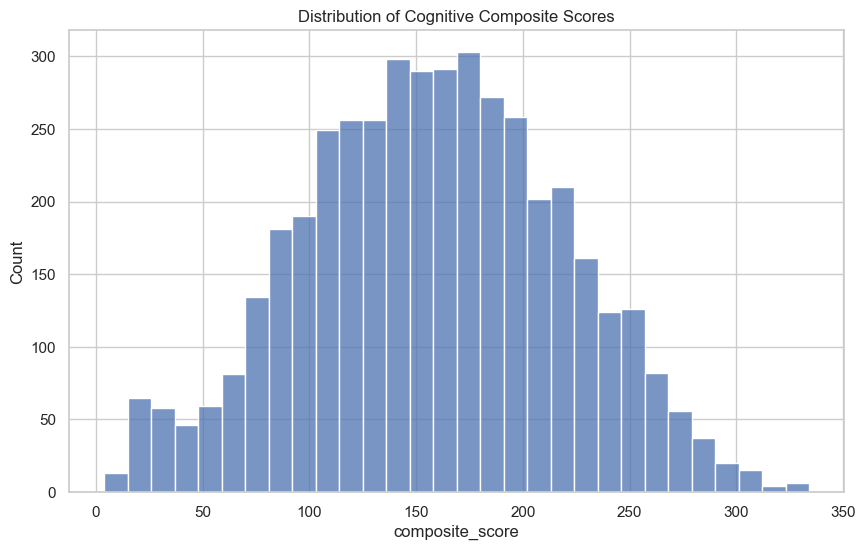


Target variable statistics:
count    4343.000000
mean      157.016809
std        60.909546
min         4.000000
25%       114.000000
50%       157.000000
75%       200.000000
max       334.000000
Name: composite_score, dtype: float64


In [4]:
# Analyze target variable distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=train_labels, x='composite_score', bins=30)
plt.title('Distribution of Cognitive Composite Scores')
plt.show()

print("\nTarget variable statistics:")
print(train_labels['composite_score'].describe())

In [5]:
# Split features by year (_03 vs _12)
features_03 = [col for col in train_features.columns if col.endswith('_03')]
features_12 = [col for col in train_features.columns if col.endswith('_12')]
other_features = [col for col in train_features.columns if not (col.endswith('_03') or col.endswith('_12'))]

print("\nFeature counts by year:")
print(f"2003 features: {len(features_03)}")
print(f"2012 features: {len(features_12)}")
print(f"Year-agnostic features: {len(other_features)}")


Feature counts by year:
2003 features: 75
2012 features: 105
Year-agnostic features: 4


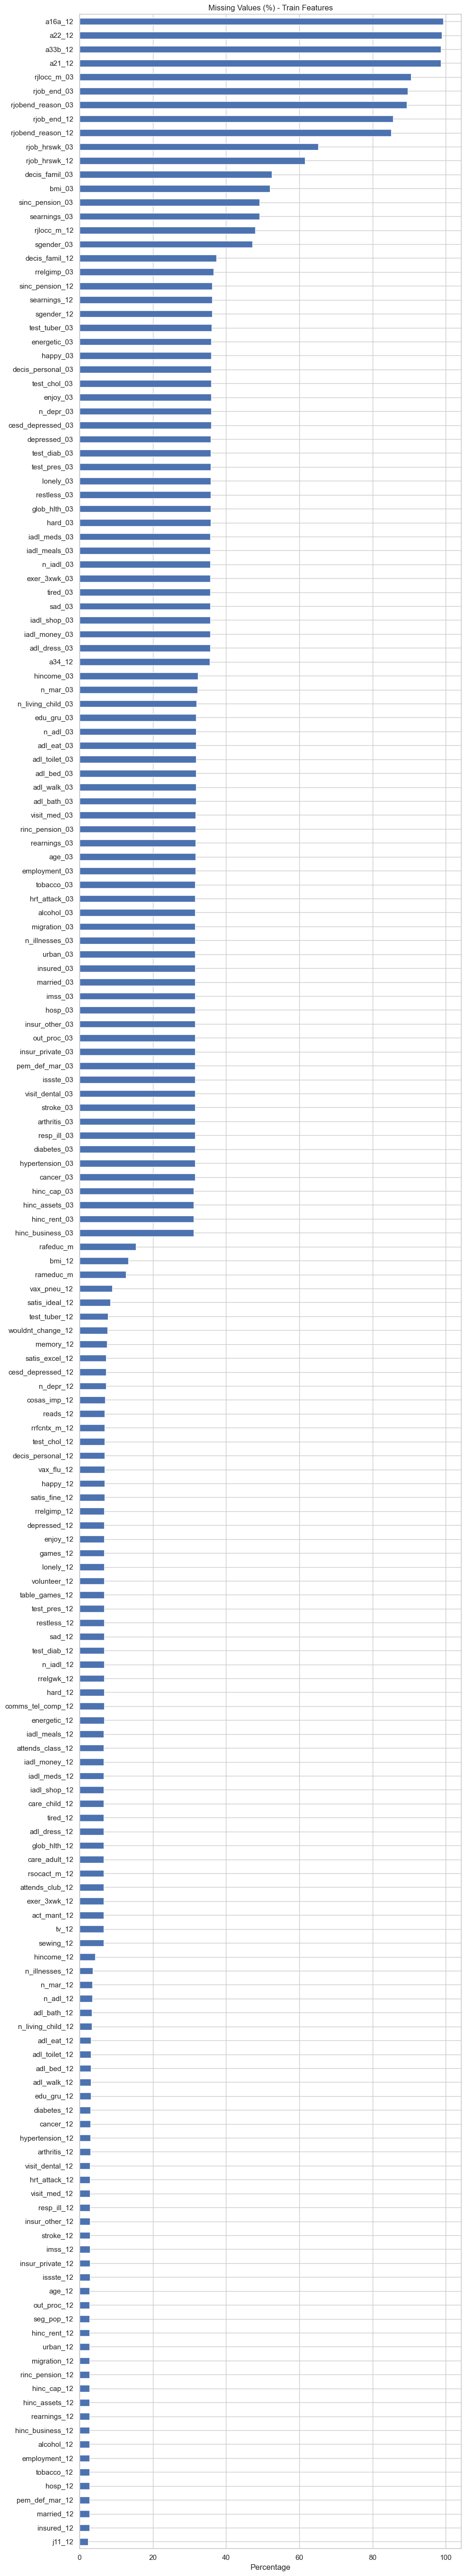

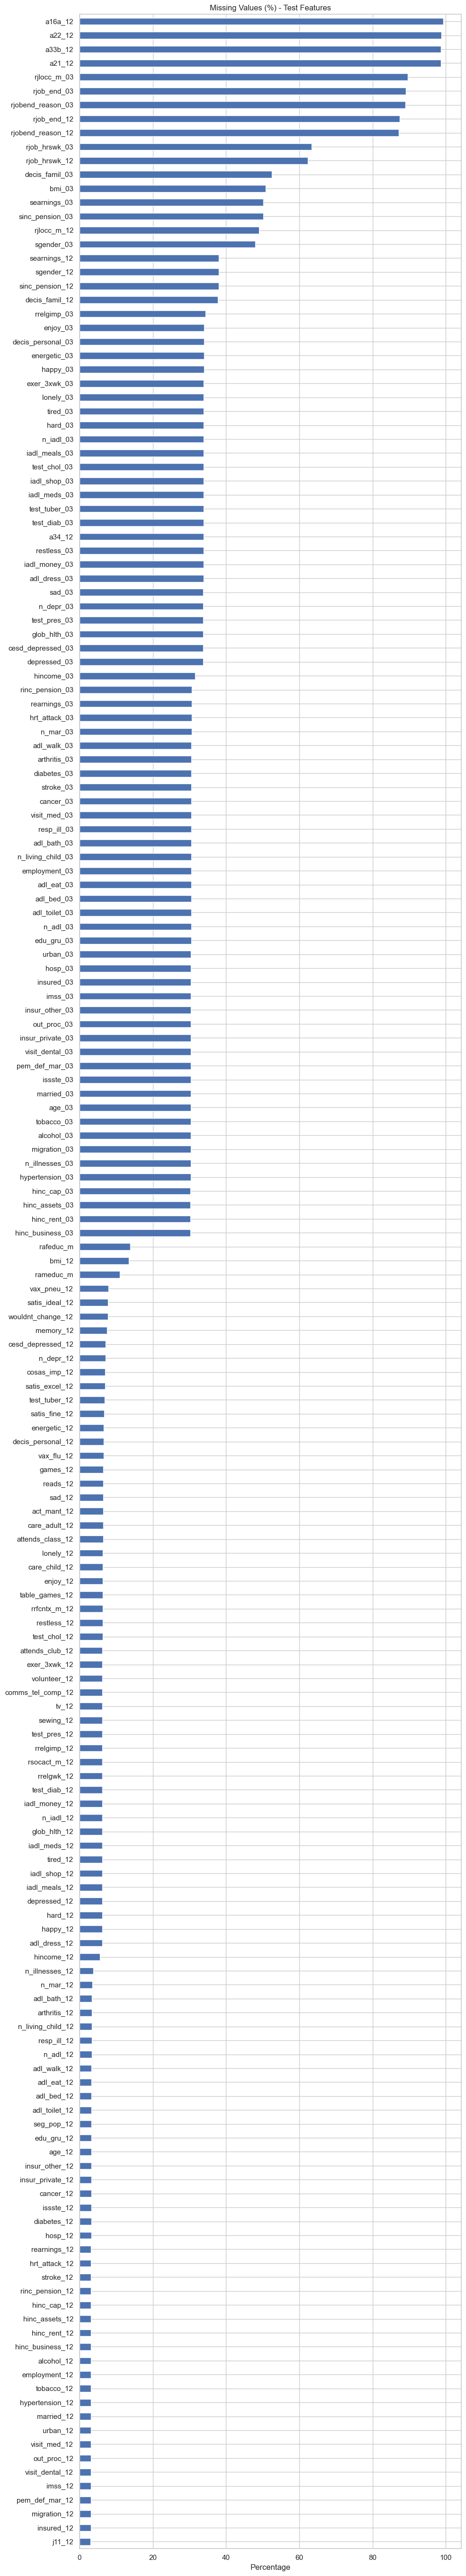

In [6]:
# Missing values analysis
def plot_missing_values(df, title):
    missing = (df.isnull().sum() / len(df)) * 100
    missing = missing[missing > 0].sort_values(ascending=True)
    
    if len(missing) > 0:
        plt.figure(figsize=(10, len(missing)*0.3))
        missing.plot(kind='barh')
        plt.title(f'Missing Values (%) - {title}')
        plt.xlabel('Percentage')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No missing values in {title}")

plot_missing_values(train_features, 'Train Features')
plot_missing_values(test_features, 'Test Features')

In [7]:
# Analyze temporal patterns
temporal_pairs = [(col_03, col_12) for col_03, col_12 in zip(features_03, features_12)]

def analyze_temporal_changes(df, feature_pair):
    col_03, col_12 = feature_pair
    if df[col_03].dtype in ['int64', 'float64'] and df[col_12].dtype in ['int64', 'float64']:
        plt.figure(figsize=(10, 6))
        plt.scatter(df[col_03], df[col_12], alpha=0.5)
        plt.xlabel(f'{col_03}')
        plt.ylabel(f'{col_12}')
        plt.title(f'Temporal Changes: {col_03} vs {col_12}')
        plt.tight_layout()
        plt.show()

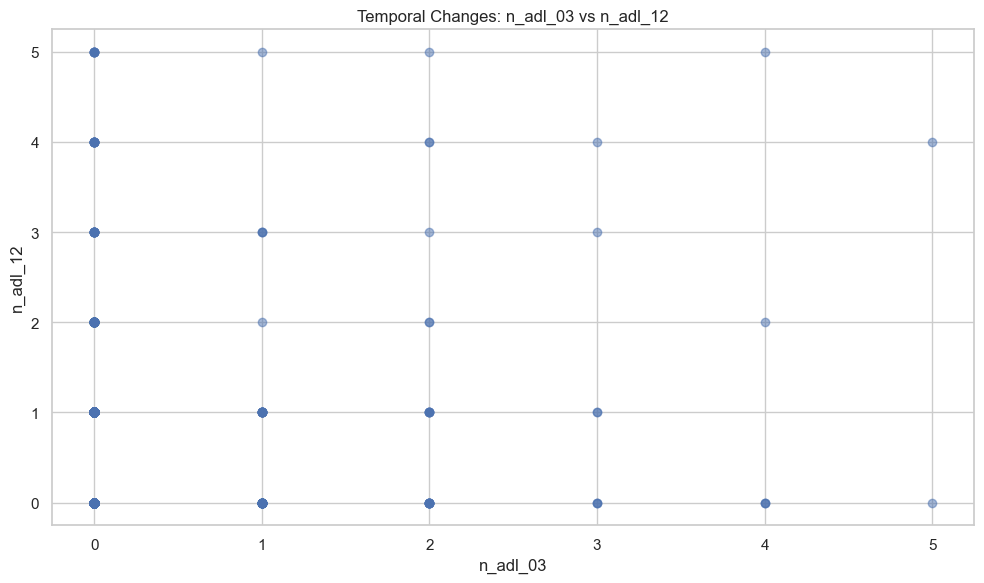

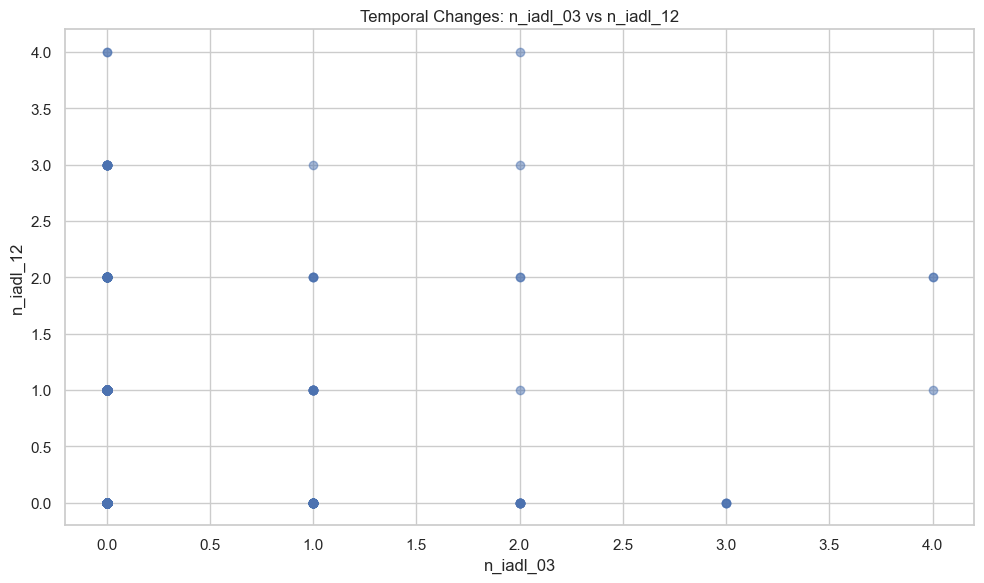

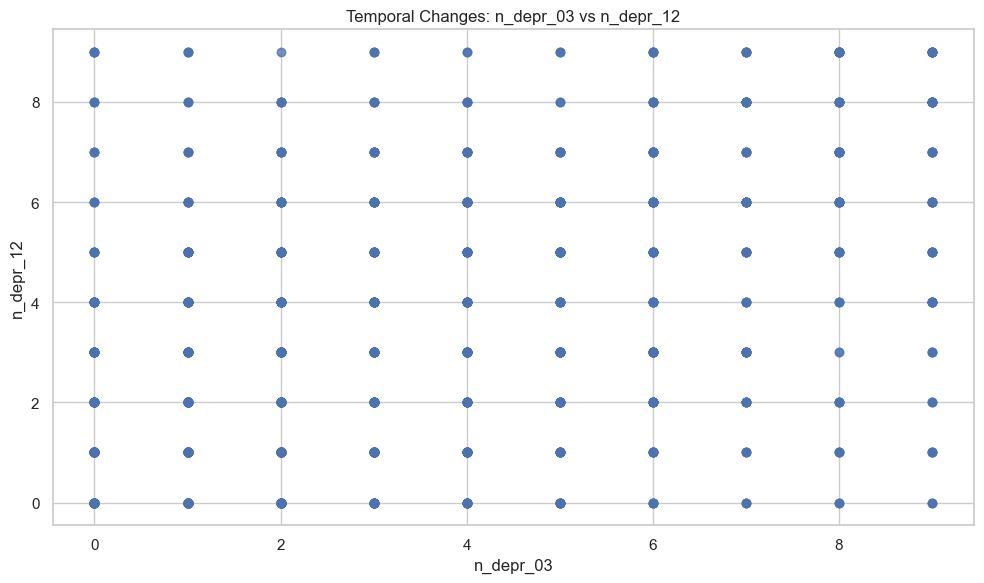

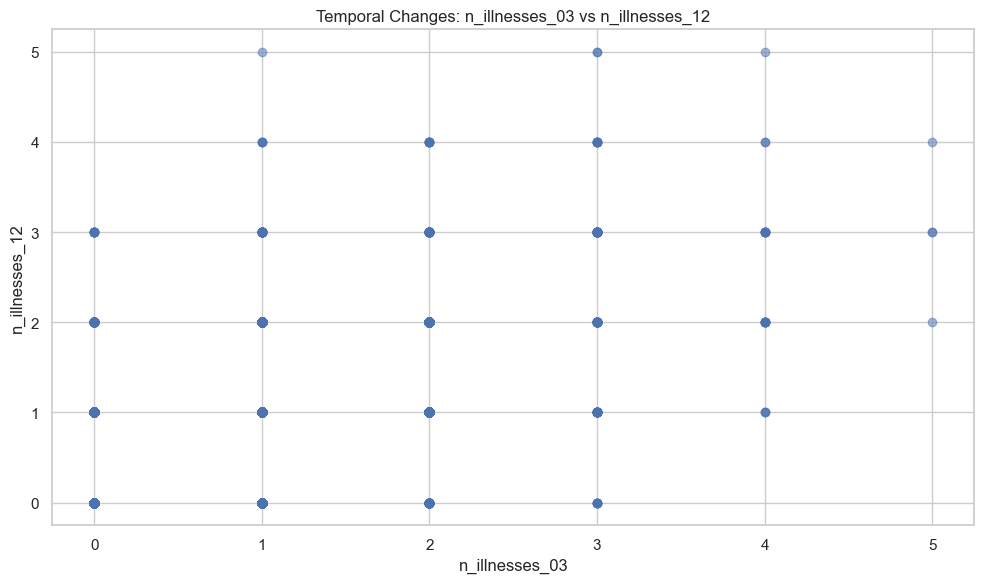

In [8]:
# Example for a few key numeric features
key_pairs = [
    ('n_adl_03', 'n_adl_12'),
    ('n_iadl_03', 'n_iadl_12'),
    ('n_depr_03', 'n_depr_12'),
    ('n_illnesses_03', 'n_illnesses_12')
]

for pair in key_pairs:
    analyze_temporal_changes(train_features, pair)

In [9]:
# Feature importance estimation using correlation with target
def calculate_feature_importance(features_df, labels_df):
    merged = features_df.merge(labels_df, on='uid', how='inner')
    numeric_cols = merged.select_dtypes(include=['int64', 'float64']).columns
    correlations = merged[numeric_cols].corr()['composite_score'].sort_values(ascending=False)
    return correlations

correlations = calculate_feature_importance(train_features, train_labels)
print("\nTop 10 feature correlations with target:")
print(correlations[:10])


Top 10 feature correlations with target:
composite_score      1.000000
reads_12             0.364368
games_12             0.300257
insured_03           0.243065
rearnings_03         0.242364
comms_tel_comp_12    0.240622
table_games_12       0.223403
visit_dental_03      0.217996
hincome_03           0.209746
searnings_03         0.190214
Name: composite_score, dtype: float64


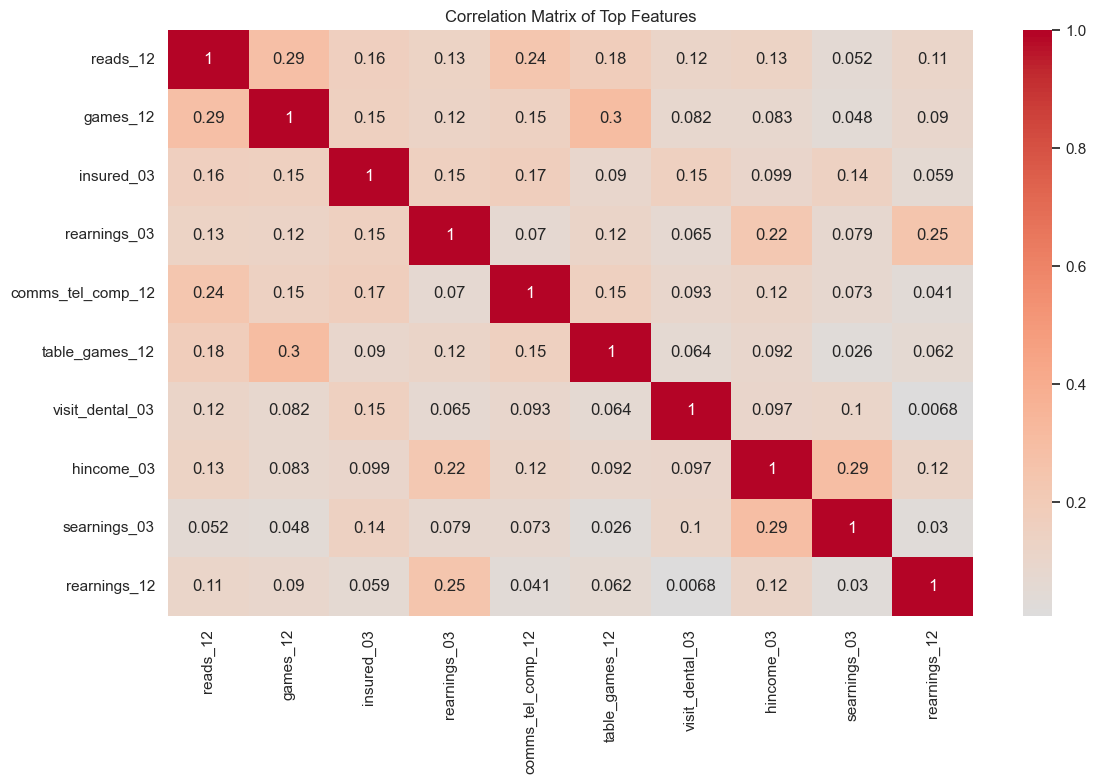

In [11]:
# Visualize important correlations
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_features[correlations.index[1:11]].corr(),
    annot=True,
    cmap='coolwarm',
    center=0
)
plt.title('Correlation Matrix of Top Features')
plt.tight_layout()
plt.show()

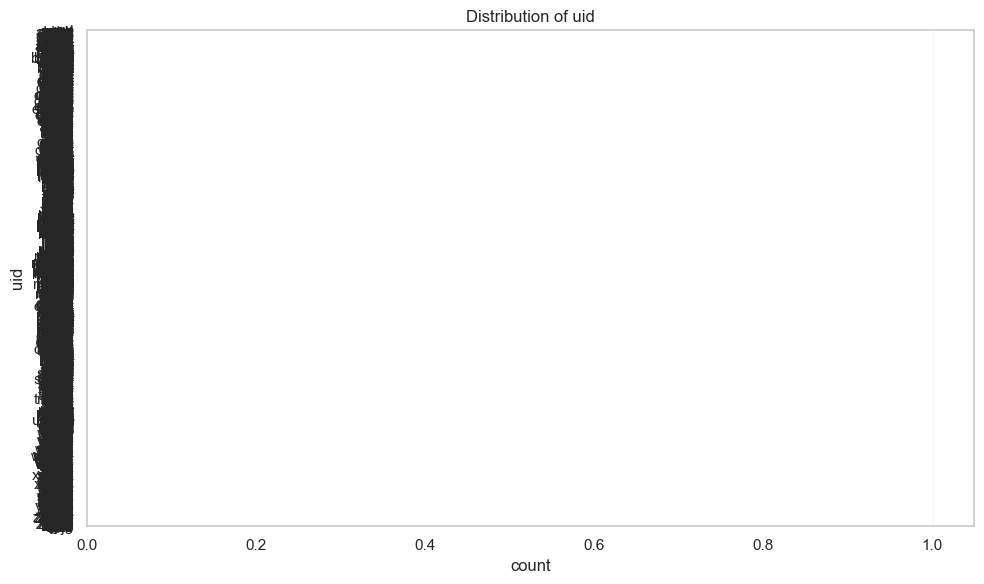

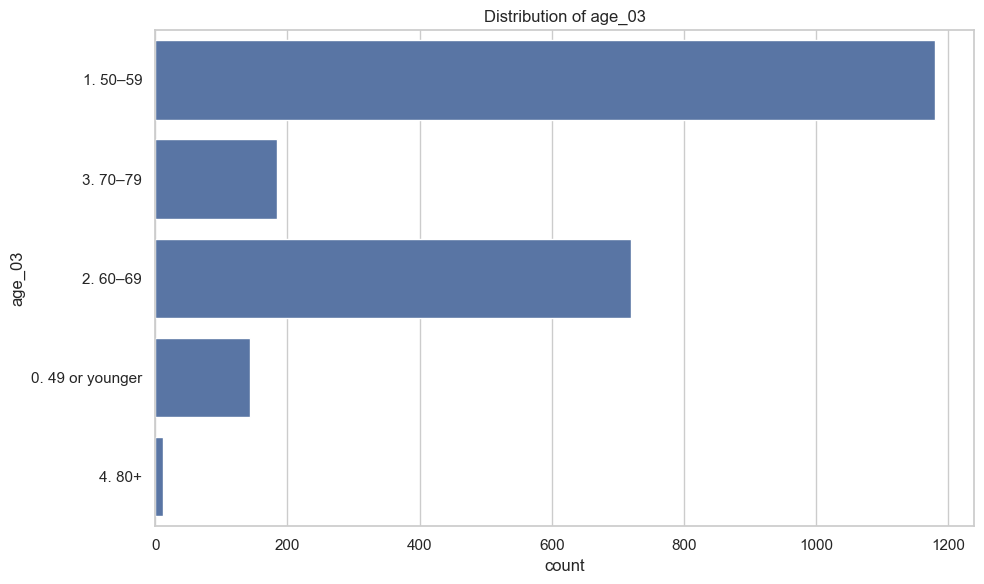

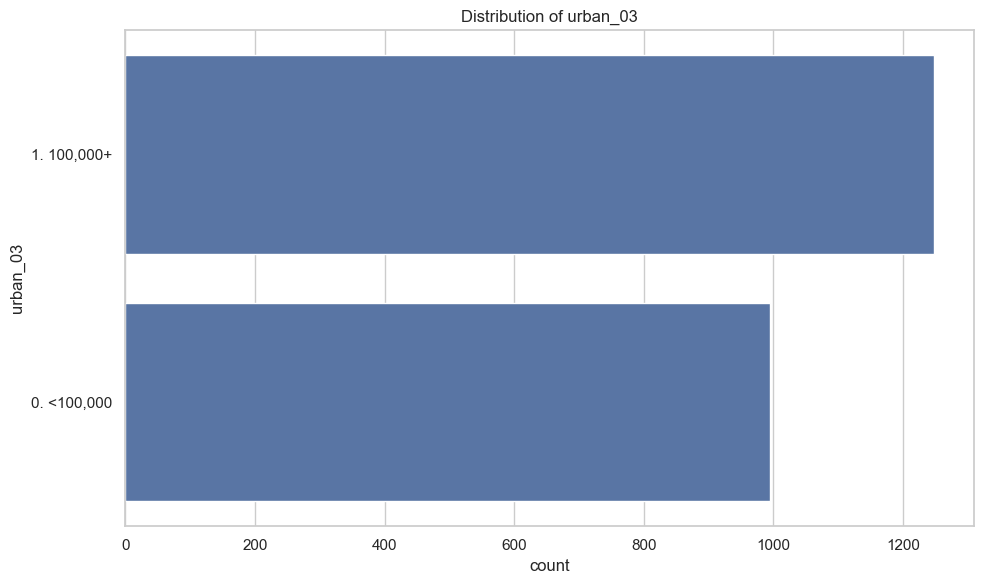

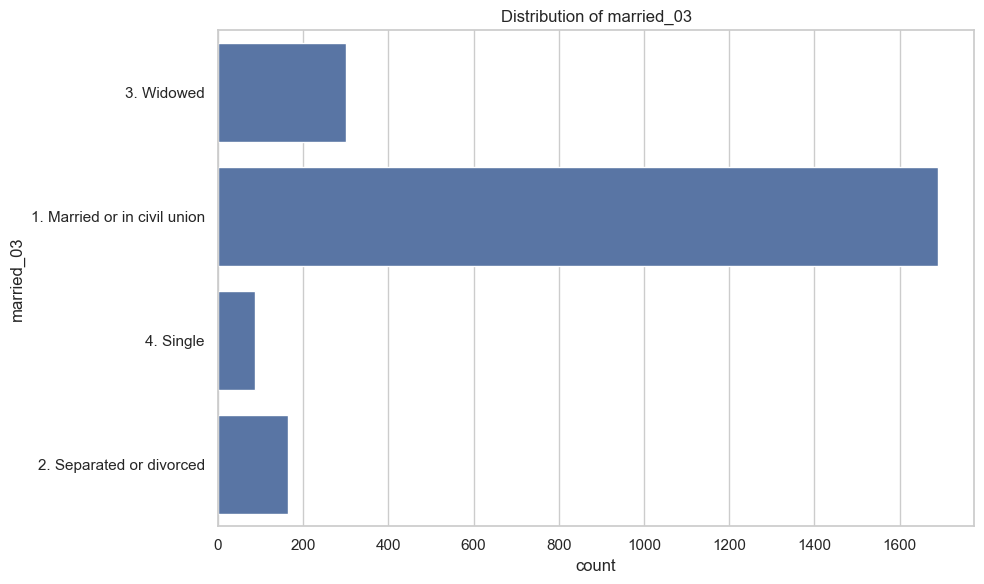

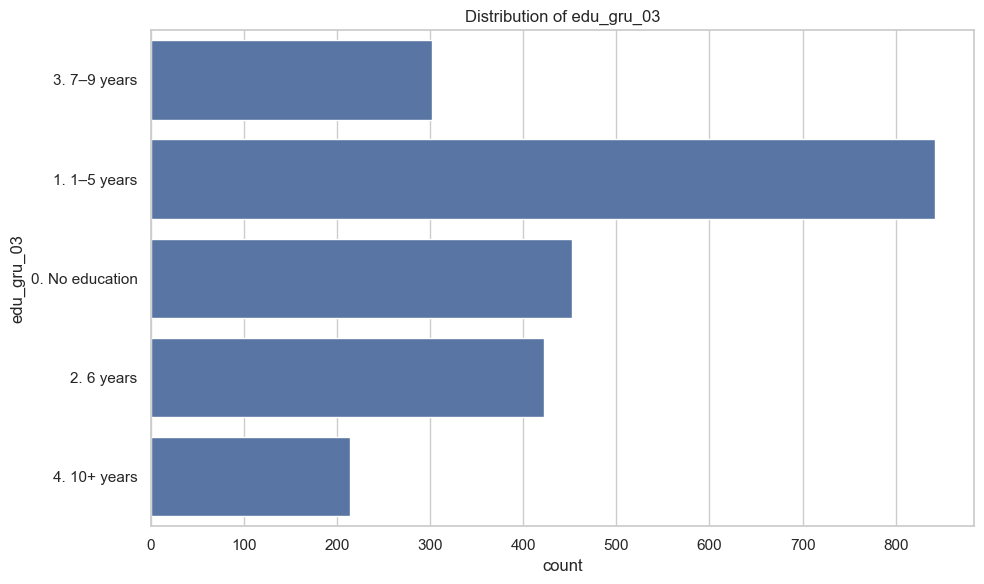

In [12]:
# Distribution of key categorical variables
categorical_cols = train_features.select_dtypes(include=['object']).columns

for col in categorical_cols[:5]:  # Show first 5 categorical variables
    plt.figure(figsize=(10, 6))
    sns.countplot(data=train_features, y=col)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

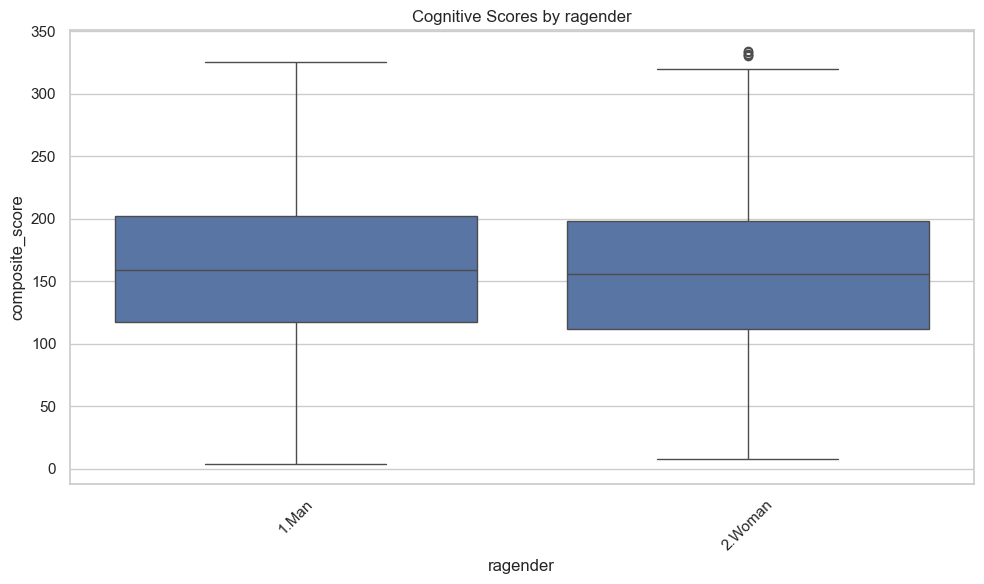

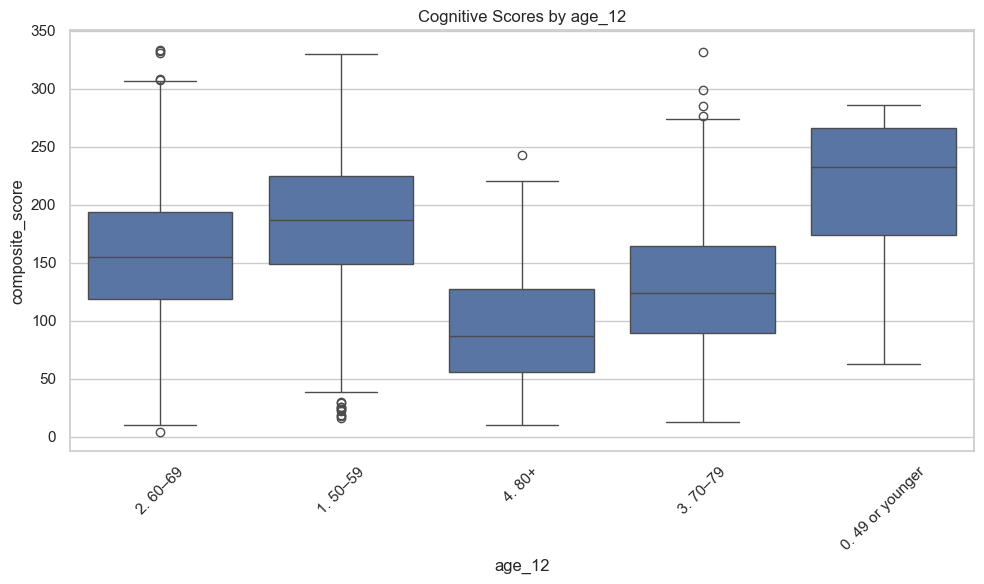

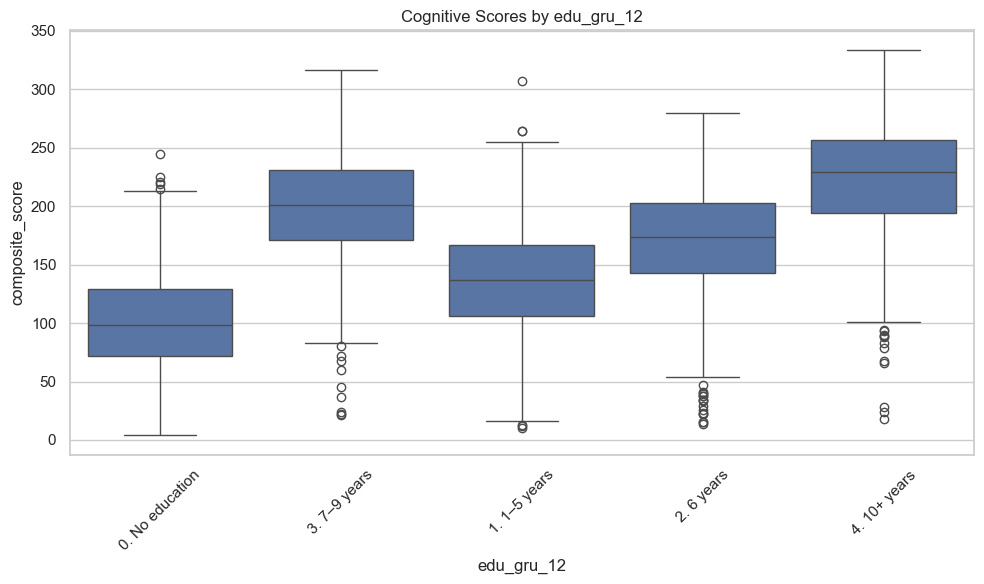

In [13]:
# Analysis by demographic groups
def analyze_scores_by_group(features_df, labels_df, group_col):
    merged = features_df.merge(labels_df, on='uid', how='inner')
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=merged, x=group_col, y='composite_score')
    plt.title(f'Cognitive Scores by {group_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

demographic_cols = ['ragender', 'age_12', 'edu_gru_12']
for col in demographic_cols:
    analyze_scores_by_group(train_features, train_labels, col)

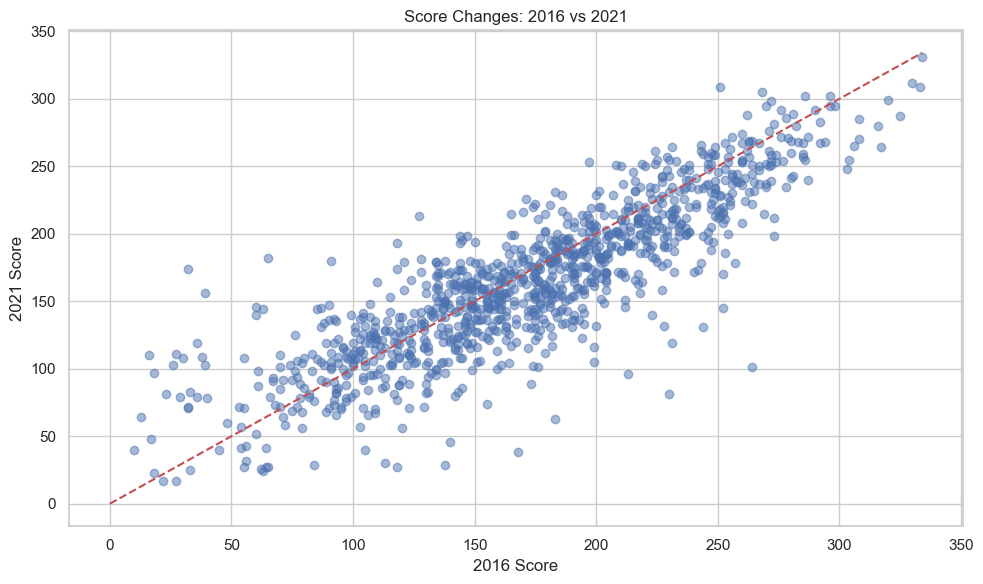


Average score change 2016-2021: -7.65


In [14]:
# Year-over-year score changes
def analyze_score_changes(labels_df):
    # Get individuals with scores in both years
    both_years = labels_df.pivot(index='uid', columns='year', values='composite_score').dropna()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(both_years[2016], both_years[2021], alpha=0.5)
    plt.plot([0, both_years.max().max()], [0, both_years.max().max()], 'r--')
    plt.xlabel('2016 Score')
    plt.ylabel('2021 Score')
    plt.title('Score Changes: 2016 vs 2021')
    plt.tight_layout()
    plt.show()
    
    # Calculate average decline
    decline = (both_years[2021] - both_years[2016]).mean()
    print(f"\nAverage score change 2016-2021: {decline:.2f}")

analyze_score_changes(train_labels)

In [15]:
# Save summary statistics
summary = {
    'n_samples': len(train_features),
    'n_features': train_features.shape[1],
    'target_mean': train_labels['composite_score'].mean(),
    'target_std': train_labels['composite_score'].std(),
    'missing_rate': (train_features.isnull().sum() / len(train_features)).mean(),
    'temporal_features': len(features_03),
    'categorical_features': len(categorical_cols)
}

print("\nSummary Statistics:")
for key, value in summary.items():
    print(f"{key}: {value}")


Summary Statistics:
n_samples: 3276
n_features: 184
target_mean: 157.01680865760994
target_std: 60.90954581423322
missing_rate: 0.22452653023305194
temporal_features: 75
categorical_features: 44
